In [78]:
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F

# read data

In [79]:
words = open('../data/names.txt', 'r').read().splitlines()

In [80]:
len(words)

32033

In [81]:
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [82]:
chars = sorted(list(set(''.join(words))))

# util 

In [83]:
itos = {}
itos[0] = '.'
itos |= {i+1: s for i, s in enumerate(chars)}

In [84]:
stoi = {s: i for i, s in itos.items()}

# build N

In [85]:
len(itos)

27

In [86]:
N = torch.zeros(len(itos), len(itos))

In [90]:
for w in words[:]:
    w2 = '.' + w + '.'
    for ch1, ch2 in zip(w2, w2[1:]):
        if ch1 != '.' and ch1 != 'a':
            # continue
            pass
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        N[ix1, ix2] += 1

In [91]:
P = N / N.sum(1, keepdim=True)

In [92]:
P[0].sum(), P[:,0].sum()

(tensor(1.), tensor(3.0222))

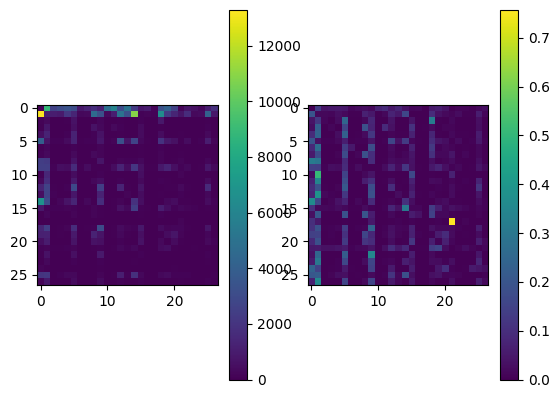

In [93]:
plt.subplot(121)
plt.imshow(N)
plt.colorbar()
plt.subplot(122)
plt.imshow(P)
plt.colorbar()
plt.show()

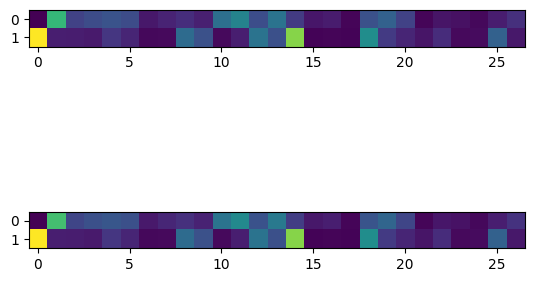

In [94]:
plt.subplot(211)
plt.imshow(N[0:2,:])
plt.subplot(212)
plt.imshow(P[0:2,:])
plt.show()

# compute loss

In [120]:
nll = 0
n = 0
for w in words[:]:
    w2 = '.' + w + '.'
    for ch1, ch2 in zip(w2, w2[1:]):
        if ch1 != '.' and ch1 != 'a':
            # continue
            pass
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        nll += -P[ix1, ix2].log().item()
        n += 1
nll/n

2.454014497322693

# train a bigram nn

## prepare data

In [96]:
xs, ys = [], []
for w in words[:]:
    w2 = '.' + w + '.'
    for ch1, ch2 in zip(w2, w2[1:]):
        if ch1 != '.' and ch1 != 'a':
            # continue
            pass
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        xs.append(ix1)
        ys.append(ix2)

In [97]:
xs = torch.tensor(xs)
ys = torch.tensor(ys)

In [98]:
xs, ys

(tensor([ 0,  5, 13,  ..., 25, 26, 24]),
 tensor([ 5, 13, 13,  ..., 26, 24,  0]))

In [99]:
xs.shape, ys.shape

(torch.Size([228146]), torch.Size([228146]))

## build a simple nn

In [100]:
w = torch.randn(len(itos), len(itos))

In [102]:
losses = []
# w = torch.randn(len(itos), len(itos), requires_grad=True)
w = torch.zeros((len(itos), len(itos)), requires_grad=True)

for i in tqdm(range(500)):
    # forward
    xenc = F.one_hot(xs, num_classes=len(itos)).float()
    logits = xenc @ w
    counts = logits.exp()
    probs = counts / counts.sum(1, keepdim=True)
    loss = -probs[torch.arange(ys.shape[0]), ys].log().mean()
    losses.append(loss.item())

    # backword
    w.grad = None
    loss.backward()

    # update
    w.data += -10.0 * w.grad

100%|████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:38<00:00, 13.00it/s]


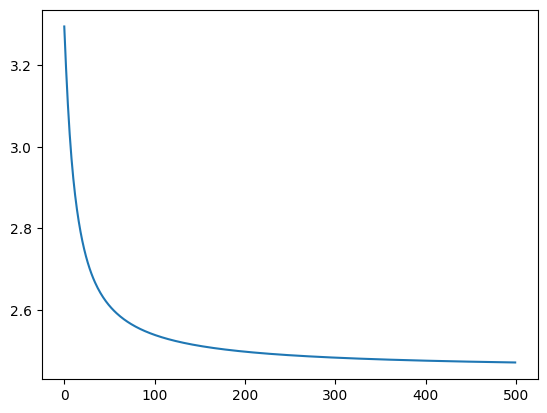

In [103]:
plt.plot(losses);

In [104]:
losses[-5:]

[2.470601797103882,
 2.4705655574798584,
 2.470529556274414,
 2.470494031906128,
 2.4704580307006836]

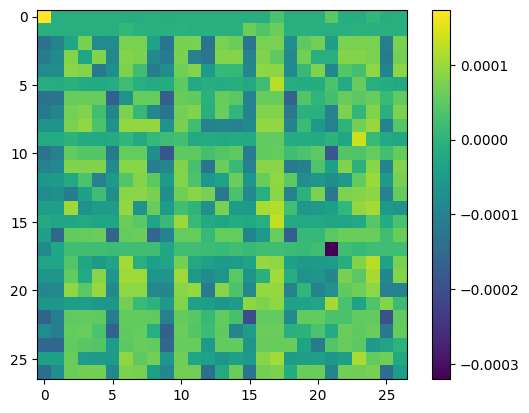

In [106]:
# plt.imshow(w.grad[0:2,])
plt.imshow(w.grad)
plt.colorbar()
plt.show()

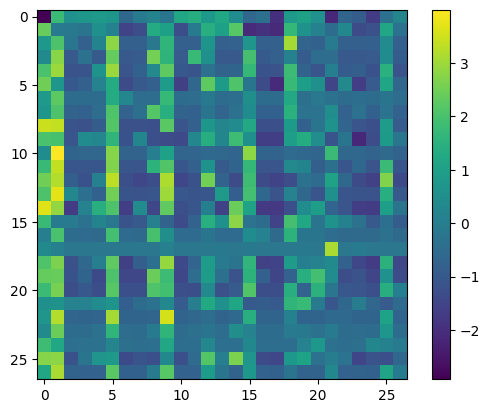

In [107]:
# plt.imshow(w.data[0:2])
plt.imshow(w.data)
plt.colorbar()
plt.show()

In [108]:
w[0].exp() / w[0].exp().sum()

tensor([0.0012, 0.1376, 0.0407, 0.0481, 0.0527, 0.0477, 0.0129, 0.0208, 0.0272,
        0.0184, 0.0755, 0.0924, 0.0490, 0.0792, 0.0357, 0.0122, 0.0160, 0.0031,
        0.0511, 0.0641, 0.0408, 0.0028, 0.0116, 0.0095, 0.0042, 0.0166, 0.0289],
       grad_fn=<DivBackward0>)

In [109]:
P[0]

tensor([0.0000, 0.1377, 0.0408, 0.0481, 0.0528, 0.0478, 0.0130, 0.0209, 0.0273,
        0.0184, 0.0756, 0.0925, 0.0491, 0.0792, 0.0358, 0.0123, 0.0161, 0.0029,
        0.0512, 0.0642, 0.0408, 0.0024, 0.0117, 0.0096, 0.0042, 0.0167, 0.0290])

In [110]:
w[1].exp() / w[1].exp().sum()

tensor([0.1959, 0.0164, 0.0159, 0.0138, 0.0307, 0.0204, 0.0040, 0.0049, 0.0688,
        0.0486, 0.0051, 0.0167, 0.0746, 0.0482, 0.1604, 0.0023, 0.0027, 0.0022,
        0.0963, 0.0329, 0.0202, 0.0112, 0.0246, 0.0047, 0.0053, 0.0605, 0.0128],
       grad_fn=<DivBackward0>)

In [111]:
P[1]

tensor([0.1960, 0.0164, 0.0160, 0.0139, 0.0308, 0.0204, 0.0040, 0.0050, 0.0688,
        0.0487, 0.0052, 0.0168, 0.0746, 0.0482, 0.1605, 0.0019, 0.0024, 0.0018,
        0.0963, 0.0330, 0.0203, 0.0112, 0.0246, 0.0048, 0.0054, 0.0605, 0.0128])

## Does the original P minimize the loss of the nn?

In [112]:
w = torch.zeros_like(P, requires_grad=True)

In [113]:
w.data[0] = P[0]

In [114]:
w.data[1] = P[1]

In [115]:
losses = []
# w = P.clone().detach().requires_grad_(True)

for i in tqdm(range(100)):
    # forward
    xenc = F.one_hot(xs, num_classes=len(itos)).float()
    logits = xenc @ w
    counts = logits.exp()
    probs = counts / counts.sum(1, keepdim=True)
    loss = -probs[torch.arange(ys.shape[0]), ys].log().mean()
    losses.append(loss.item())

    # backword
    w.grad = None
    loss.backward()
    break
    
    # update
    w.data += -50.0 * w.grad

  0%|                                                                                                      | 0/100 [00:00<?, ?it/s]


In [116]:
w.grad[0:2,]

tensor([[ 0.0050, -0.0136, -0.0005, -0.0015, -0.0021, -0.0015,  0.0032,  0.0022,
          0.0013,  0.0025, -0.0052, -0.0075, -0.0016, -0.0057,  0.0002,  0.0033,
          0.0028,  0.0046, -0.0019, -0.0037, -0.0005,  0.0047,  0.0034,  0.0037,
          0.0044,  0.0027,  0.0011],
        [-0.0227,  0.0029,  0.0030,  0.0033,  0.0009,  0.0024,  0.0047,  0.0046,
         -0.0045, -0.0017,  0.0046,  0.0029, -0.0054, -0.0016, -0.0176,  0.0050,
          0.0049,  0.0050, -0.0085,  0.0006,  0.0024,  0.0037,  0.0018,  0.0046,
          0.0045, -0.0034,  0.0035]])

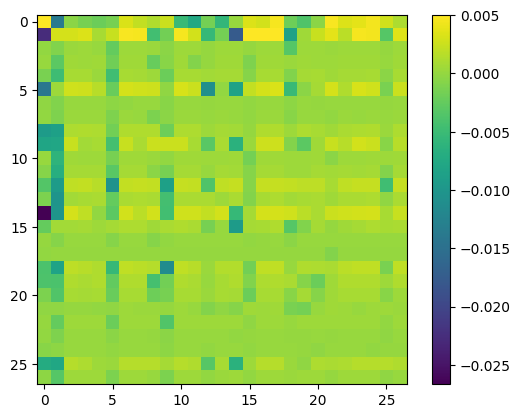

In [118]:
# plt.imshow(w.grad[0:2])
plt.imshow(w.grad)
plt.colorbar()
plt.show()

## What kind of loss does P minimize?

In [119]:
losses = []
w = torch.zeros((len(itos), len(itos)), requires_grad=True)

for i in tqdm(range(100)):
    # forward
    xenc = F.one_hot(xs, num_classes=len(itos)).float()
    logits = xenc @ w
    counts = logits.exp()
    probs = counts / counts.sum(1, keepdim=True)
    loss = -probs[torch.arange(ys.shape[0]), ys].log().mean()
    losses.append(loss.item())

    # backword
    w.grad = None
    loss.backward()
    break
    
    # update
    w.data += -50.0 * w.grad

  0%|                                                                                                      | 0/100 [00:00<?, ?it/s]
